In [11]:
def adam_peer(x, y, w, b, alpha, momentw, momentb, sqw, sqb, beta1, beta2, epsilon, momentum_guidance_w, momentum_guidance_b, guidance_w, guidance_b, gradientw_max, gradientb_max):
    dl_dw = 0
    dl_db = 0
    N = len(x)
    
    mw, mb = momentw, momentb
    sw, sb = sqw, sqb
    
    for i in range(N):
        dl_dw += -2*x[i]*(y[i] - (w*x[i] +b))
        dl_db += -2*(y[i] - (w*x[i] + b))
    gradientw_current = (1/float(N))*dl_dw
    gradientb_current = (1/float(N))*dl_db
    
    #mw = (beta1*mw) - ((1 - beta1)*(gradientw_current))
    #mw = ((guidance_w-0.00000001)*mw) - ((1 - (guidance_w-0.00000001))*(gradientw_current))
    #mw = guidance_w*((beta1*mw) - ((1 - beta1)*(gradientw_current)))
    
    mw = (((1-guidance_w)*mw) - ((guidance_w)*(gradientw_current))) #XXXXXXXXXXXXXXXit works somewhat good
    #mb = (beta1*mb) - ((1 - beta1)*(gradientb_current))
    #mb = ((guidance_b-0.00000001)*mb) - ((1 - (guidance_b-0.00000001))*(gradientb_current))
    mb = guidance_b*((beta1*mb) - ((1 - beta1)*(gradientb_current)))
    #mb = (((1-guidance_b)*mb) - ((guidance_b)*(gradientb_current))) #XXXXXXXXXXXXXXXXXXXit works somewhat good
    
    sw= (beta2*sw) + ((1 - beta2)*(gradientw_current)**2)
    #sw = guidance_w*((beta2*sw) + ((1 - beta2)*(gradientw_current)**2))
    sb = (beta2*sb) + ((1 - beta2)*(gradientb_current)**2)
    #sb = guidance_b*((beta2*sb) + ((1 - beta2)*(gradientb_current)**2))
    
    mw_hat = mw / (1 - beta1)
    mb_hat = mb / (1 - beta1)
    
    sw_hat = sw / (1 - beta2)
    sb_hat = sb / (1 - beta2)
    
    #w = w + (alpha*((guidance_w*momentum_guidance_w) + mw_hat)) / np.sqrt(sw_hat + epsilon)
    w = w + (alpha*((guidance_w*(momentum_guidance_w / (1 - beta1))) + mw_hat)) / np.sqrt(sw_hat + epsilon)
    #the problem is in any of these guidance_w, momentum_guidance_w, mw_hat, sw_hat
    #b = b + (alpha*((guidance_b*momentum_guidance_b) + mb_hat)) / np.sqrt(sb_hat + epsilon)
    b = b + (alpha*((guidance_b*(momentum_guidance_b / (1 - beta1))) + mb_hat)) / np.sqrt(sb_hat + epsilon)
    
    for i in range(N):
        dl_dw += -2*x[i]*(y[i] - (w*x[i] +b))
        dl_db += -2*(y[i] - (w*x[i] + b))
    gradientw = (1/float(N))*dl_dw
    gradientb = (1/float(N))*dl_db
    
    if gradientw > gradientw_max:
        gradientw_max = gradientw
    if gradientb > gradientb_max:
        gradientb_max = gradientb
    
    return w, b, mw, mb, sw, sb, gradientw_max, gradientb_max, gradientw, gradientb

In [12]:
def momentum_peer(x, y, w, b, alpha, momentw, momentb, beta):
    dl_dw = 0
    dl_db = 0
    N = len(x)
    mw, mb = momentw, momentb
    for i in range(N):
        dl_dw += -2*x[i]*(y[i] - (w*x[i] +b))
        dl_db += -2*(y[i] - (w*x[i] + b))
        
    mw = beta*mw - alpha*(1/float(N))*dl_dw
    mb = beta*mb - alpha*(1/float(N))*dl_db
    
    w = w+mw
    b = b+mb
    
    return w, b, mw, mb

In [13]:
def guidance_decay(gradientw, gradientb, max_gradient_w, max_gradient_b):
    #guidance_w = 1 - (np.exp(-abs(gradientw)))
    guidance_w = 1 - (np.exp(-abs(((max_gradient_w - gradientw)  / max_gradient_w))*10))
    
    #guidance_w = 1 - (np.exp(-abs(abs(max_gradient_w) - abs(gradientw)) / abs(max_gradient_w)))
    #guidance_b = 1 - (np.exp(-abs(gradientb)))
    guidance_b = 1 - (np.exp(-abs(((max_gradient_b - gradientb) / max_gradient_b))*10))
    
    #guidance_b = 1 - (np.exp(-abs(abs(max_gradient_b) - abs(gradientb)) / abs(max_gradient_b)))
    return guidance_w, guidance_b

In [14]:
from matplotlib.pyplot import figure
import time
def train(x, y, w1, b1, w2, b2, alpha, epochs, beta1, beta2, epsilon):
    avg_loss_list = []
    w_list = []
    b_list = []
    img_list = []
    pred_val_at_diff_epoch = []
    mw1, mb1, mw2, mb2 = 0, 0, 0, 0
    sqw1, sqb1, sqw2, sqb2 = 0, 0, 0, 0
    guidance_w2, guidance_b2 = 1, 1
    gradientw_max, gradientb_max = 0.00000001, 0.00000001
    for num_of_epochs in range(epochs):
        xy = pd.concat([x, y], axis = 1)
        indexes = xy.index
        rand_indexes = np.random.choice(indexes, 15)
        xtrain = []
        ytrain = []
        for i in rand_indexes:
            xtrain.append(x[i])
            ytrain.append(y[i])
        w1, b1, mw1, mb1 = momentum_peer(x, y, w1, b1, alpha, mw1, mb1, 0.9)
        #gradientw1 = (671 - gradientw1) / 671 #not correct, 671 is cost not gradient replace with 1/N*dl_dw
        #gradientb1 = (671 - gradientb1) / 671 #not correct, above eq
        w2, b2, mw2, mb2, sw2, sb2, gradientw_max, gradientb_max, gradientw2, gradientb2 = adam_peer(xtrain, ytrain, w2, b2, alpha, mw2, mb2, sqw2, sqb2, beta1, beta2, epsilon, mw1, mb1, guidance_w2, guidance_b2, gradientw_max, gradientb_max)
        guidance_w2, guidance_b2 = guidance_decay(gradientw2, gradientb2, gradientw_max, gradientb_max)
        #guidance_w2, guidance_b2 = guidance_decay(gradientw2, gradientb2)
        #w2, b2, mw2, mb2, sw2, sb2, gradientw2, gradientb2 = adam_peer(xtrain, ytrain, w2, b2, alpha, mw2, mb2, sqw2, sqb2, beta1, beta2, epsilon, mw1, mb1, guidance_w1, guidance_b1)
        #guidance_w2, guidance_b2 = guidance_decay(gradientw2, gradientb2)
        
        if num_of_epochs%10 == 0:
            avg_loss_val1 = avg_loss(x, y, w1, b1)
            avg_loss_val2 = avg_loss(x, y, w2, b2)
            if avg_loss_val1 < avg_loss_val2:
                avg_loss_list.append(avg_loss_val1)
                w, b = w1, b1 
            elif avg_loss_val1 >= avg_loss_val2:
                avg_loss_list.append(avg_loss_val2)
                w, b = w2, b2
            w_list.append(w)
            b_list.append(b)
        if num_of_epochs%500 == 0:
            print("epoch: ", num_of_epochs,"average loss: ",avg_loss_val2)
            print(f"Momentum leader: gradient_w2 = {gradientw2}, gradient_b2 = {gradientb2}, MAX_w_gradient = {gradientw_max} and b = {gradientb_max}")
            print(f"Momentum leader: mw1 = {mw1}, mb1 = {mb1}")
            print(f"Momentum leader: guidance_w2 = {guidance_w2}, guidance_b2 = {guidance_b2}")
            #print(f"Adam follower: w2 = {w2}, b2 = {b2}")
            print(f"Adam follower: mw2 = {mw2}, mb2 = {mb2}, sw2 = {sw2}, sb2 = {sb2}")
            
            figure(figsize = (15, 10))
            plt.title(f"Epoch: {num_of_epochs}")
            plt.xlabel("X")
            plt.ylabel("y")
            plt.xlim(0, 9)
            plt.ylim(0, 50)
            
            plt.scatter(x, y)
            xt = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
            yt = []
            for i in range(10):
                yt.append(predict(xt[i], w2, b2))
                
            plt.plot(xt, yt, color = "red")
            
            plt.savefig(f"{num_of_epochs}.png")
            img_list.append(f"{num_of_epochs}.png")
            
            plt.show()
            
            if avg_loss(x, y, w2, b2) <= 38:
                return w_list, b_list, avg_loss_list, w, b, img_list, pred_val_at_diff_epoch
            print(avg_loss_val1, w1, b1)
            print(avg_loss_val2, w2, b2)
    return w_list, b_list, avg_loss_list, w, b, img_list, pred_val_at_diff_epoch

In [15]:
def avg_loss(x, y, w, b):
    N = len(x)
    total_error = 0
    for i in range(N):
        total_error += (y[i] - (w*x[i]+b))**2
    return total_error/float(N)

In [16]:
def predict(x, w, b):
    return w*x+b

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
dataset = load_boston()
df = pd.DataFrame(data = dataset.data, columns = dataset.feature_names)
df["Y"] = dataset.target
X = pd.concat((df["LSTAT"], df["RM"]), axis = 1)
y = pd.DataFrame(df["Y"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

epoch:  0 average loss:  668.296002620705
Momentum leader: gradient_w2 = -666.8889627982225, gradient_b2 = -96.98621244897046, MAX_w_gradient = 1e-08 and b = 1e-08
Momentum leader: mw1 = 0.31688613697270474, mb1 = 0.04843027295285366
Momentum leader: guidance_w2 = 1.0, guidance_b2 = 1.0
Adam follower: mw2 = 333.8920533333333, mb2 = 4.855999999999999, sw2 = 1114.839032791496, sb2 = 23.580736000000023


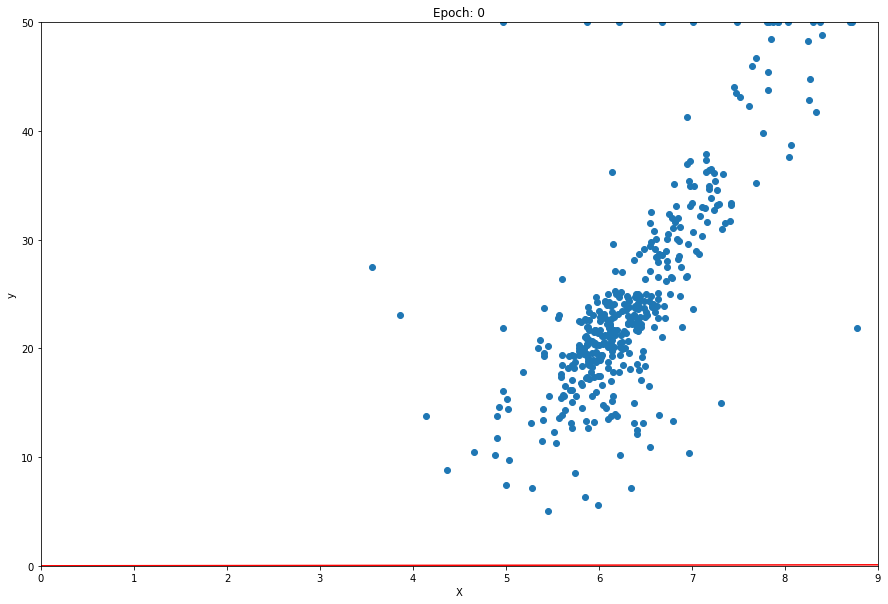

573.0312769351891 0.31688613697270474 0.04843027295285366
668.296002620705 0.010009490676212845 0.001009973285183044
epoch:  500 average loss:  57.91274417193319
Momentum leader: gradient_w2 = -111.97551337217725, gradient_b2 = -14.003779256527524, MAX_w_gradient = 105.33660732484002 and b = 18.14076840665894
Momentum leader: mw1 = 0.0012724411052219893, mb1 = -0.008166153587200839
Momentum leader: guidance_w2 = 0.9999999989025278, guidance_b2 = 0.999999979838827
Adam follower: mw2 = 56.44978833825644, mb2 = 1.653733269169494, sw2 = 31.866255341224115, sb2 = 0.49994335868865764


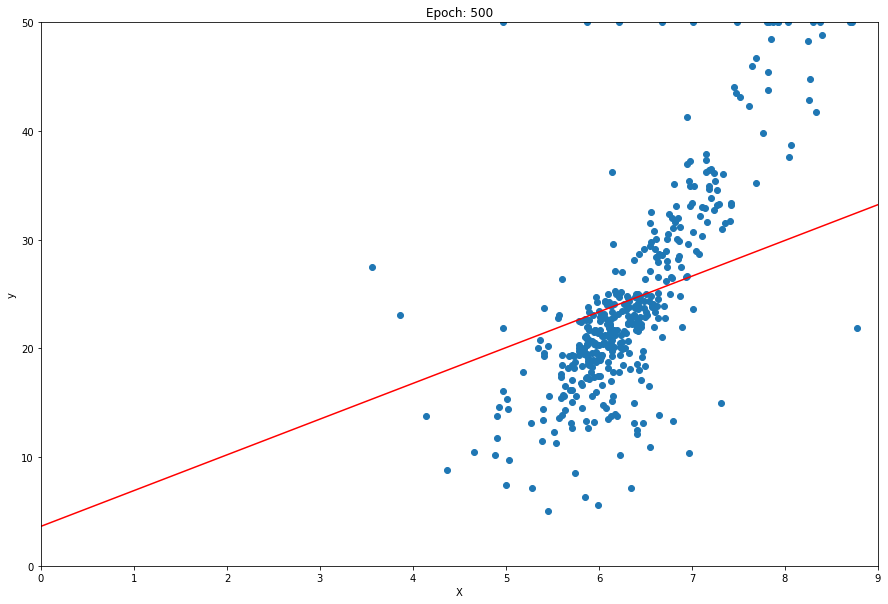

51.02845938424181 4.4686897495199105 -3.689214870927712
57.91274417193319 3.287122139722965 3.6307365377373895
epoch:  1000 average loss:  56.81757443862753
Momentum leader: gradient_w2 = 22.069978607428073, gradient_b2 = 5.7580538728542745, MAX_w_gradient = 141.62222572045204 and b = 23.426776222689117
Momentum leader: mw1 = 0.0011191956086148529, mb1 = -0.007182668982979155
Momentum leader: guidance_w2 = 0.9997843017883042, guidance_b2 = 0.9994697201879101
Adam follower: mw2 = -11.554020793618376, mb2 = -1.4903977025657422, sw2 = 1.3172378166130099, sb2 = 0.08689783771588815


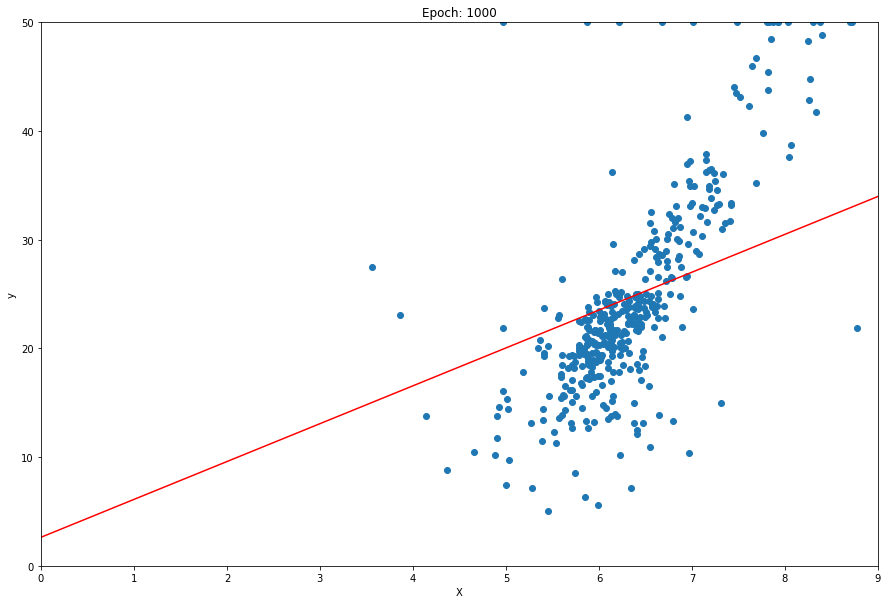

48.0243788980234 5.065703135431925 -7.5206715854229635
56.81757443862753 3.4832465873945226 2.622985351688528
epoch:  1500 average loss:  54.20457031697487
Momentum leader: gradient_w2 = 33.63227818370185, gradient_b2 = 7.994410358009856, MAX_w_gradient = 160.7076087537025 and b = 25.642761956001667
Momentum leader: mw1 = 0.000984406121869017, mb1 = -0.006317629611639393
Momentum leader: guidance_w2 = 0.999631930201558, guidance_b2 = 0.9989743113858396
Adam follower: mw2 = -17.17047715976075, mb2 = -0.5530538930896486, sw2 = 2.948315849521432, sb2 = 0.16456869839242372


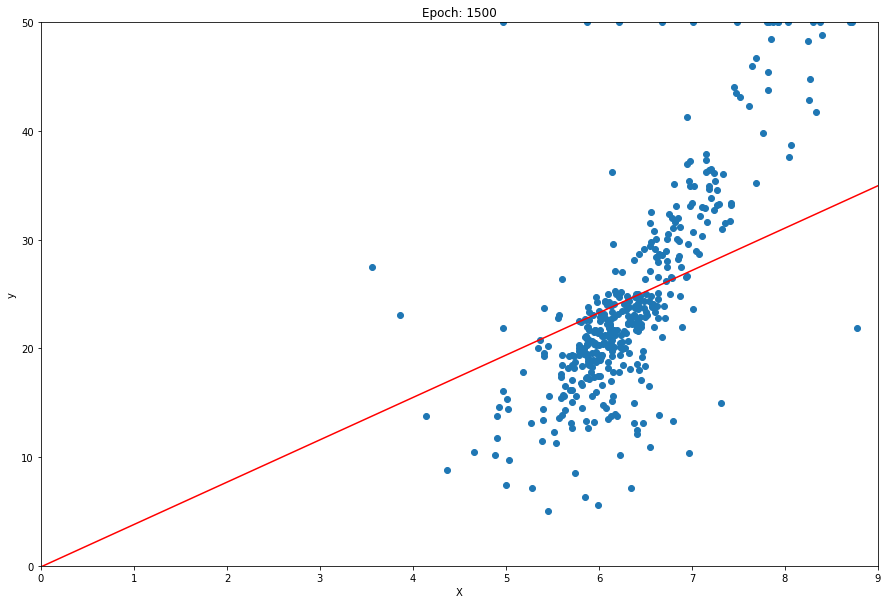

45.700314375897186 5.590815660366833 -10.890689673763678
54.20457031697487 3.8948390984907957 -0.09721627381288087
epoch:  2000 average loss:  52.65159588988837
Momentum leader: gradient_w2 = 36.87292552631194, gradient_b2 = 6.886437535511418, MAX_w_gradient = 160.7076087537025 and b = 25.642761956001667
Momentum leader: mw1 = 0.0008658499062306263, mb1 = -0.005556770610541024
Momentum leader: guidance_w2 = 0.999549696749159, guidance_b2 = 0.9993341666974206
Adam follower: mw2 = -18.824486644788017, mb2 = -0.4815341806381971, sw2 = 3.543711571566069, sb2 = 0.12290165161462543


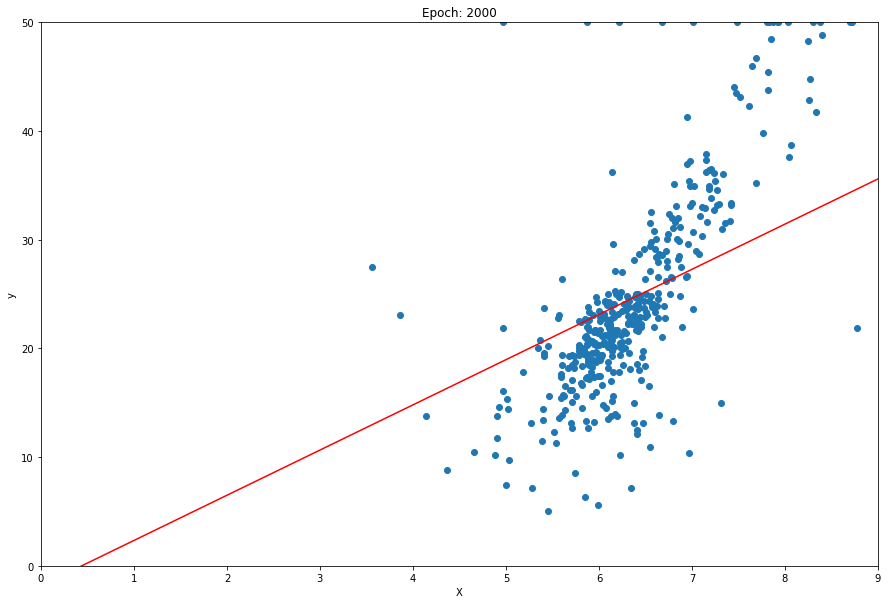

43.90233461876857 6.052686650779025 -13.854842152057481
52.65159588988837 4.156527681672503 -1.82461400557387
epoch:  2500 average loss:  51.84136630144829
Momentum leader: gradient_w2 = -117.80324421592024, gradient_b2 = -14.768462312665688, MAX_w_gradient = 160.7076087537025 and b = 25.642761956001667
Momentum leader: mw1 = 0.0007615719198252343, mb1 = -0.004887545094648239
Momentum leader: guidance_w2 = 0.999999970245462, guidance_b2 = 0.9999998568410525
Adam follower: mw2 = 59.33979579977506, mb2 = 0.1677980447107364, sw2 = 35.212928915830524, sb2 = 0.5550270726530276


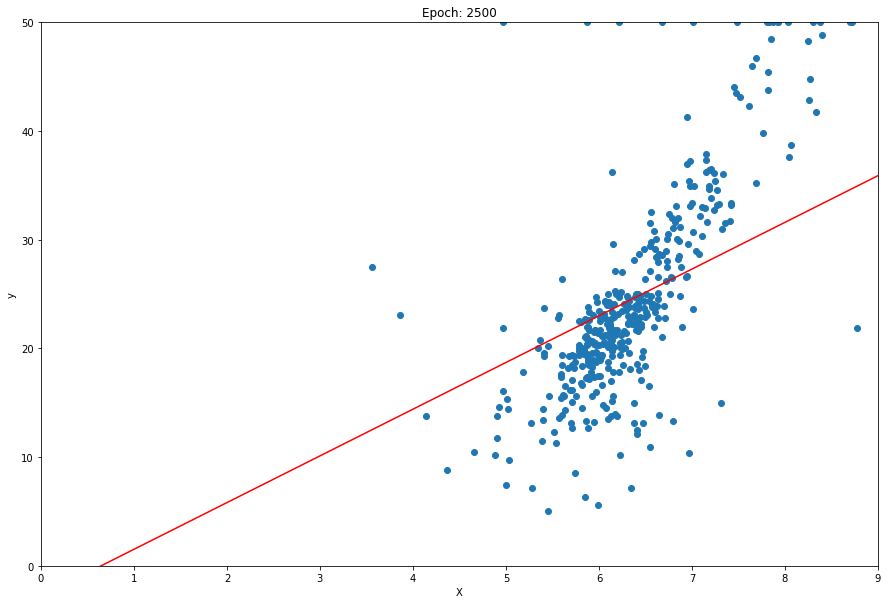

42.511352924298734 6.458932553618199 -16.46200914174607
51.84136630144829 4.2960317308619915 -2.7790599746847313
epoch:  3000 average loss:  50.95375009120024
Momentum leader: gradient_w2 = 0.973432908853152, gradient_b2 = 1.9501479981905319, MAX_w_gradient = 160.7076087537025 and b = 25.642761956001667
Momentum leader: mw1 = 0.0006698525747856957, mb1 = -0.004298917253648162
Momentum leader: guidance_w2 = 0.9999517651285655, guidance_b2 = 0.9999028732546563
Adam follower: mw2 = -0.9387525028780026, mb2 = -0.9717739383601297, sw2 = 0.008808923546078028, sb2 = 0.010957778154019849


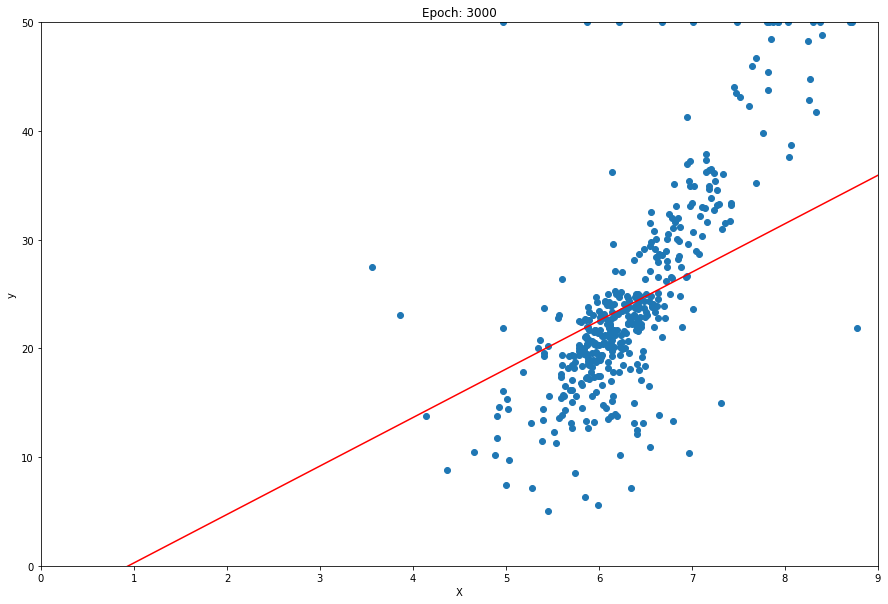

41.435239543890084 6.8162525347374485 -18.7551839233735
50.95375009120024 4.456915930856793 -4.191660679039622
epoch:  3500 average loss:  48.87622424729606
Momentum leader: gradient_w2 = 29.276389875060804, gradient_b2 = 6.483794346953225, MAX_w_gradient = 160.7076087537025 and b = 25.642761956001667
Momentum leader: mw1 = 0.0005891793805237666, mb1 = -0.003781180366795977
Momentum leader: guidance_w2 = 0.9997193163375278, guidance_b2 = 0.9994309210753962
Adam follower: mw2 = -14.9847448783576, mb2 = 1.3955578903909949, sw2 = 2.2454880527342564, sb2 = 0.10878789078528901


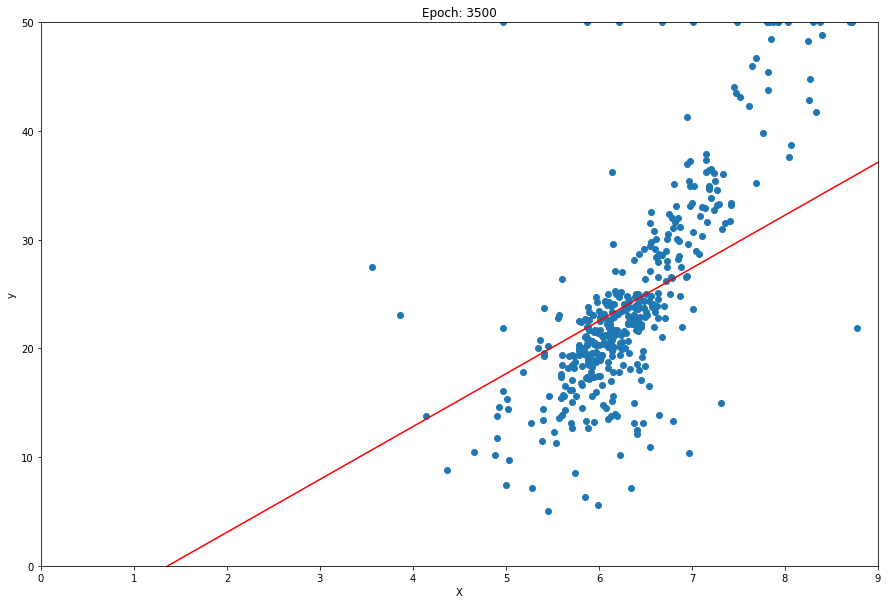

40.60271959621669 7.130538950956668 -20.772181913870565
48.87622424729606 4.860448411928854 -6.6345318676469045
epoch:  4000 average loss:  41.809261893687754
Momentum leader: gradient_w2 = -70.49346226902554, gradient_b2 = -8.19290704298294, MAX_w_gradient = 160.7076087537025 and b = 25.642761956001667
Momentum leader: mw1 = 0.0005182220021254588, mb1 = -0.0033257967350058598
Momentum leader: guidance_w2 = 0.9999994350011333, guidance_b2 = 0.9999981401549721
Adam follower: mw2 = 35.68258834830814, mb2 = 0.5290459553768652, sw2 = 12.73261730191536, sb2 = 0.17328373882388384


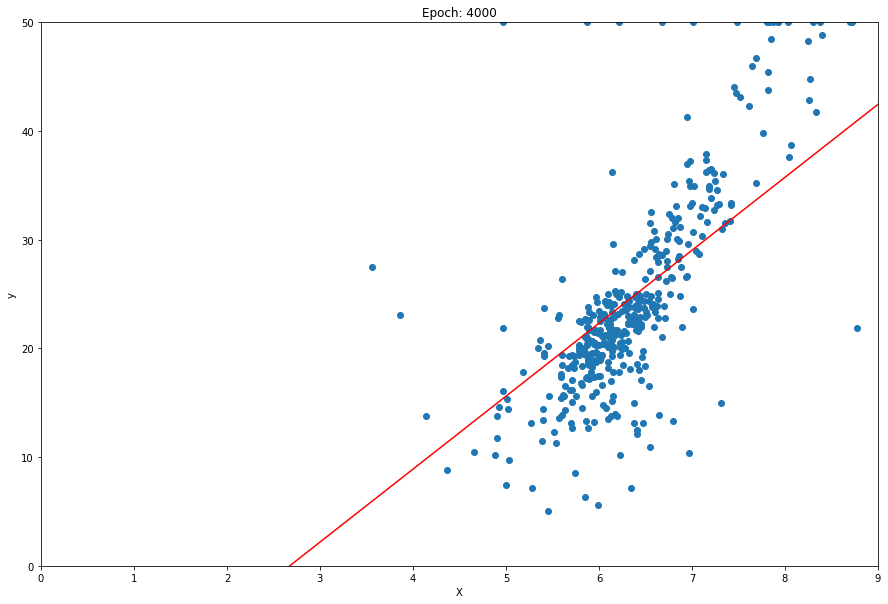

39.95865227404396 7.406974517505496 -22.5462642586894
41.809261893687754 6.710654132534251 -17.953977808189155
epoch:  4500 average loss:  41.401532604074724
Momentum leader: gradient_w2 = -14.98643436976081, gradient_b2 = -1.0360054714283526, MAX_w_gradient = 160.7076087537025 and b = 25.642761956001667
Momentum leader: mw1 = 0.00045581032256809497, mb1 = -0.0029252568906011096
Momentum leader: guidance_w2 = 0.9999821325152622, guidance_b2 = 0.9999696894516442
Adam follower: mw2 = 7.9214040140884014, mb2 = 0.014682549326277853, sw2 = 0.627481192788194, sb2 = 0.003400853298531749


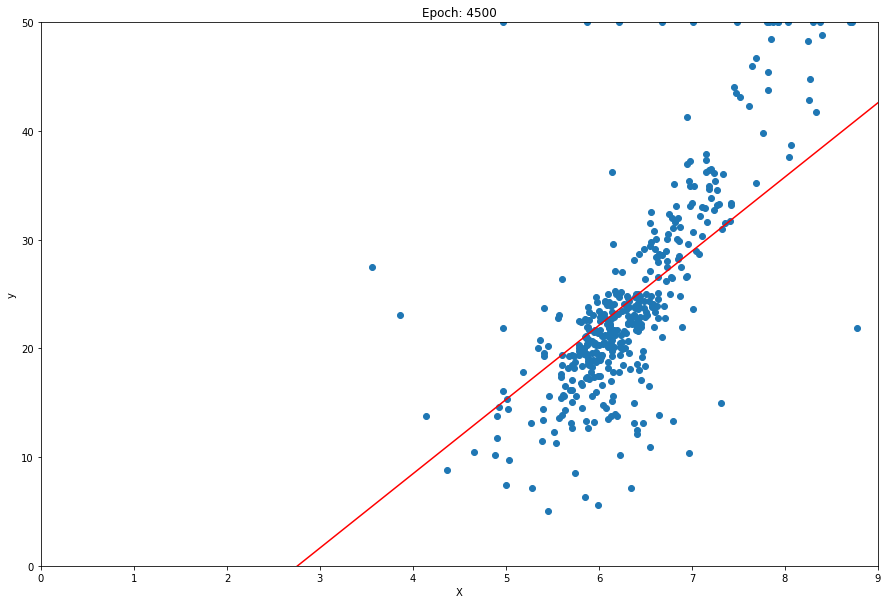

39.46037866912908 7.650117773177959 -24.106686322085856
41.401532604074724 6.824842172531203 -18.833926644490354
epoch:  5000 average loss:  41.2825216999681
Momentum leader: gradient_w2 = 38.650617011747265, gradient_b2 = 4.752243153510659, MAX_w_gradient = 160.7076087537025 and b = 25.642761956001667
Momentum leader: mw1 = 0.0004009151469973501, mb1 = -0.0025729557630329533
Momentum leader: guidance_w2 = 0.9994970263631833, guidance_b2 = 0.9997103249166339
Adam follower: mw2 = -19.67601053569247, mb2 = 0.34626889576848274, sw2 = 3.871805741690037, sb2 = 0.05925932257550677


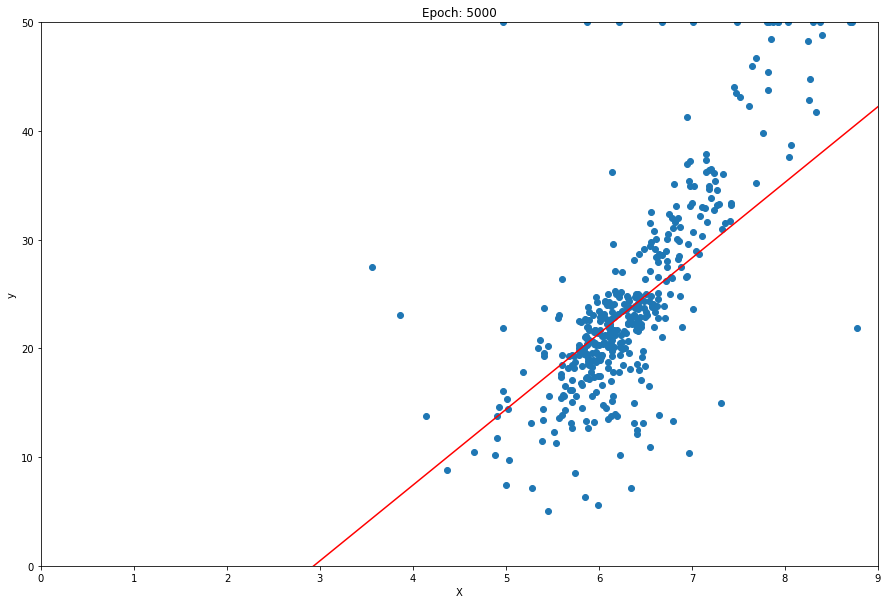

39.074896318437354 7.863978252555039 -25.479180120384243
41.2825216999681 6.961237730596579 -20.42254741466062
epoch:  5500 average loss:  42.07502845660903
Momentum leader: gradient_w2 = -4.491707751650281, gradient_b2 = -1.094067735709415, MAX_w_gradient = 172.89264262201903 and b = 25.642761956001667
Momentum leader: mw1 = 0.00035263123087408824, mb1 = -0.0022630837584878692
Momentum leader: guidance_w2 = 0.9999649872230337, guidance_b2 = 0.999970368054101
Adam follower: mw2 = 2.770989501268601, mb2 = 0.5722144690280677, sw2 = 0.07677782151096836, sb2 = 0.003891369527373438


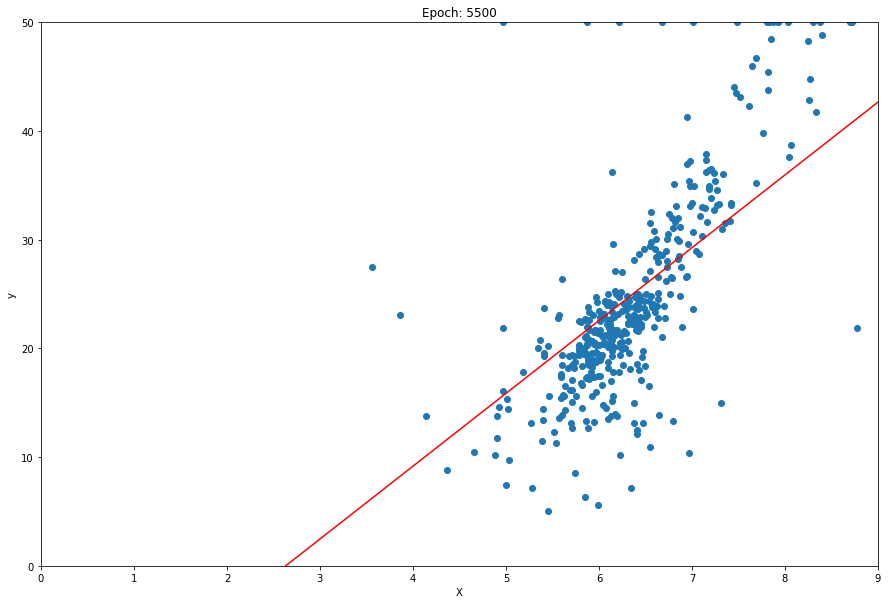

38.7766733316504 8.052082604916771 -26.68637865375239
42.07502845660903 6.697316871305087 -17.62685121637811
epoch:  6000 average loss:  41.871847388605644
Momentum leader: gradient_w2 = 18.349482522491762, gradient_b2 = 2.772379154256321, MAX_w_gradient = 195.14182275460618 and b = 28.797005071724396
Momentum leader: mw1 = 0.0003101623521061173, mb1 = -0.0019905309572421388
Momentum leader: guidance_w2 = 0.9998837403822918, guidance_b2 = 0.9998811048129661
Adam follower: mw2 = -9.535421029877936, mb2 = 0.3294388966668219, sw2 = 0.90926296863451, sb2 = 0.020879675723479416


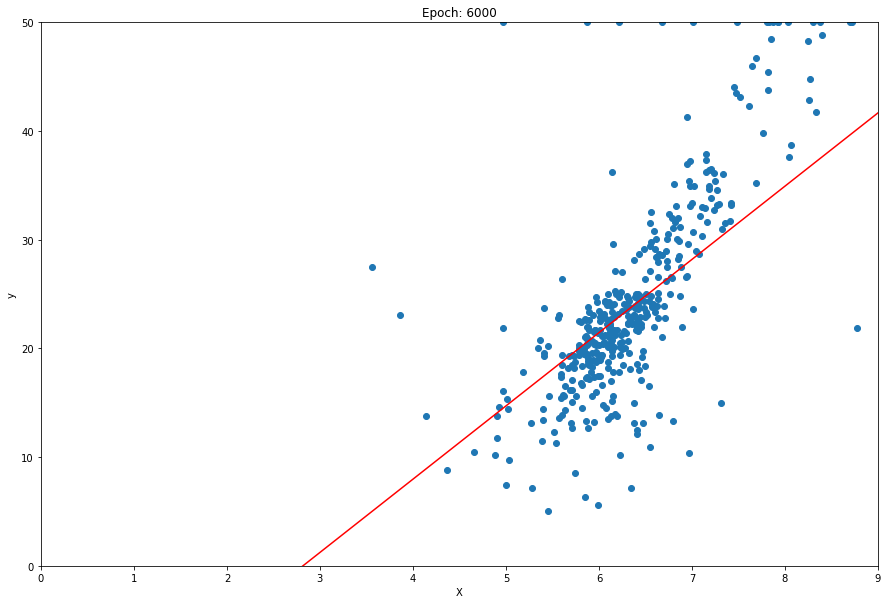

38.54595732172534 8.21753275017265 -27.74818913389666
41.871847388605644 6.7378592166691975 -18.983886340257925
epoch:  6500 average loss:  40.831292303920705
Momentum leader: gradient_w2 = -0.560269091381862, gradient_b2 = 0.46440936469325084, MAX_w_gradient = 195.14182275460618 and b = 28.797005071724396
Momentum leader: mw1 = 0.0002728081810153252, mb1 = -0.0017508028489351144
Momentum leader: guidance_w2 = 0.9999558850074856, guidance_b2 = 0.9999466549825289
Adam follower: mw2 = -0.5916705749756217, mb2 = -1.9667416087690763, sw2 = 0.0028489432315518403, sb2 = 0.0012834112763287955


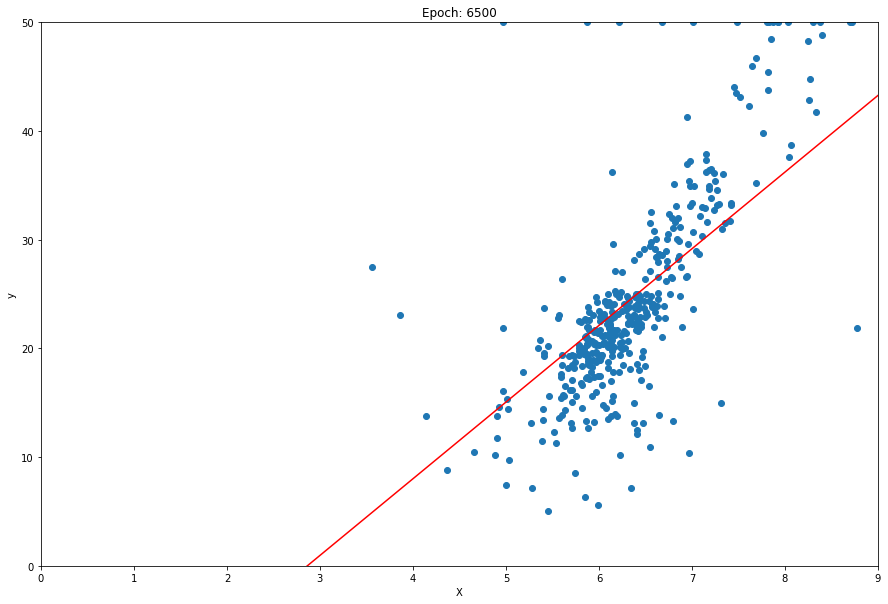

38.36746713285946 8.36305703082592 -28.682121262358212
40.831292303920705 7.051663936511207 -20.200822338182363
epoch:  7000 average loss:  40.50250744126265
Momentum leader: gradient_w2 = 61.69817217856332, gradient_b2 = 9.969720621185315, MAX_w_gradient = 195.14182275460618 and b = 28.797005071724396
Momentum leader: mw1 = 0.0002399527316042865, mb1 = -0.001539946216202788
Momentum leader: guidance_w2 = 0.9989280658757065, guidance_b2 = 0.9985525203806463
Adam follower: mw2 = -31.247451297406492, mb2 = -0.65891786851416, sw2 = 9.764731966772734, sb2 = 0.2548898571709407


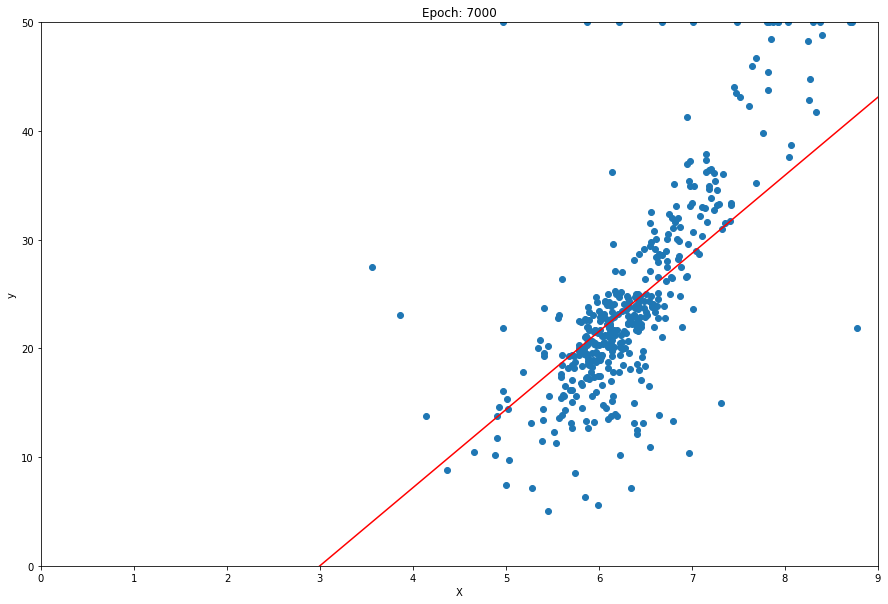

38.22938071427189 8.49105520348934 -29.503575972858155
40.50250744126265 7.183189853987491 -21.544867221658897
epoch:  7500 average loss:  40.232072255577194
Momentum leader: gradient_w2 = -4.977221831258661, gradient_b2 = -0.2741782503594398, MAX_w_gradient = 195.14182275460618 and b = 28.797005071724396
Momentum leader: mw1 = 0.0002110542036906485, mb1 = -0.0013544839444598234
Momentum leader: guidance_w2 = 0.9999648208381471, guidance_b2 = 0.9999587232298519
Adam follower: mw2 = 2.975736077399212, mb2 = 0.3689702126340687, sw2 = 0.08903917386955824, sb2 = 0.0004676366622374975


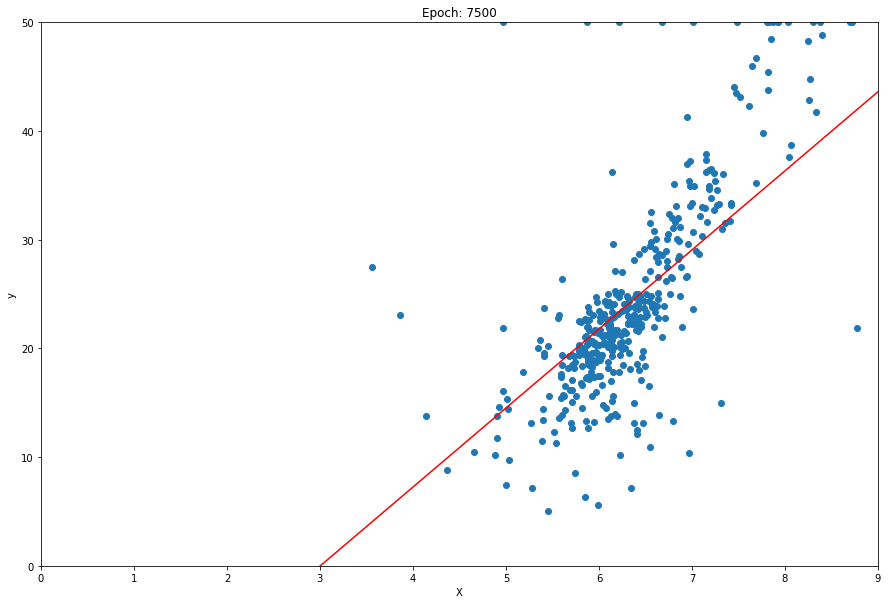

38.12255210302157 8.603638011881387 -30.22609939917411
40.232072255577194 7.271799055993958 -21.84548228623226
epoch:  8000 average loss:  40.27241489746939
Momentum leader: gradient_w2 = 23.629062312425088, gradient_b2 = 4.139459679677254, MAX_w_gradient = 195.14182275460618 and b = 28.797005071724396
Momentum leader: mw1 = 0.00018563604839094626, mb1 = -0.001191357682817748
Momentum leader: guidance_w2 = 0.9998476201091244, guidance_b2 = 0.9998088664441047
Adam follower: mw2 = -12.252581994895742, mb2 = -1.790336230419734, sw2 = 1.501368871854713, sb2 = 0.04579026914944287


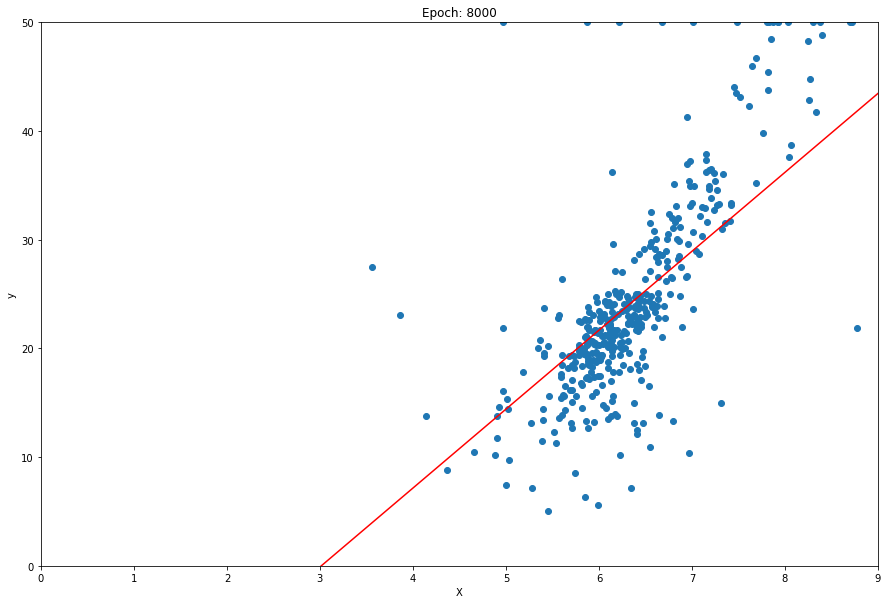

38.03990565380227 8.70266199387813 -30.861606256585127
40.27241489746939 7.259409261278588 -21.886305039992838
epoch:  8500 average loss:  40.1697365874327
Momentum leader: gradient_w2 = 17.484086477637526, gradient_b2 = -0.444385252743605, MAX_w_gradient = 195.14182275460618 and b = 28.797005071724396
Momentum leader: mw1 = 0.00016327910962911477, mb1 = -0.0010478774105919934
Momentum leader: guidance_w2 = 0.9998887835010021, guidance_b2 = 0.9999610922260347
Adam follower: mw2 = -9.052304653074483, mb2 = 0.19670812414766492, sw2 = 0.818647942185891, sb2 = 0.00029868462127732816


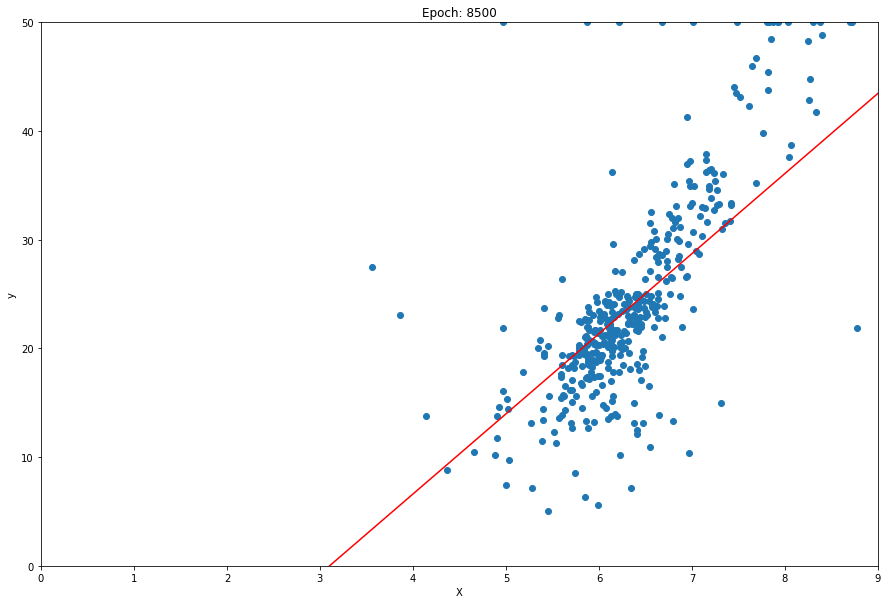

37.97596739336237 8.789760096603949 -31.42057632053961
40.1697365874327 7.370115519096056 -22.876725566333644
epoch:  9000 average loss:  38.84901827481733
Momentum leader: gradient_w2 = -32.353631728323826, gradient_b2 = -3.5953751551741955, MAX_w_gradient = 195.14182275460618 and b = 28.797005071724396
Momentum leader: mw1 = 0.00014361471207970946, mb1 = -0.0009216770777286012
Momentum leader: guidance_w2 = 0.9999913500306232, guidance_b2 = 0.9999869734892142
Adam follower: mw2 = 16.58536449959542, mb2 = -0.14386932725137858, sw2 = 2.750733119463135, sb2 = 0.03462785647715037


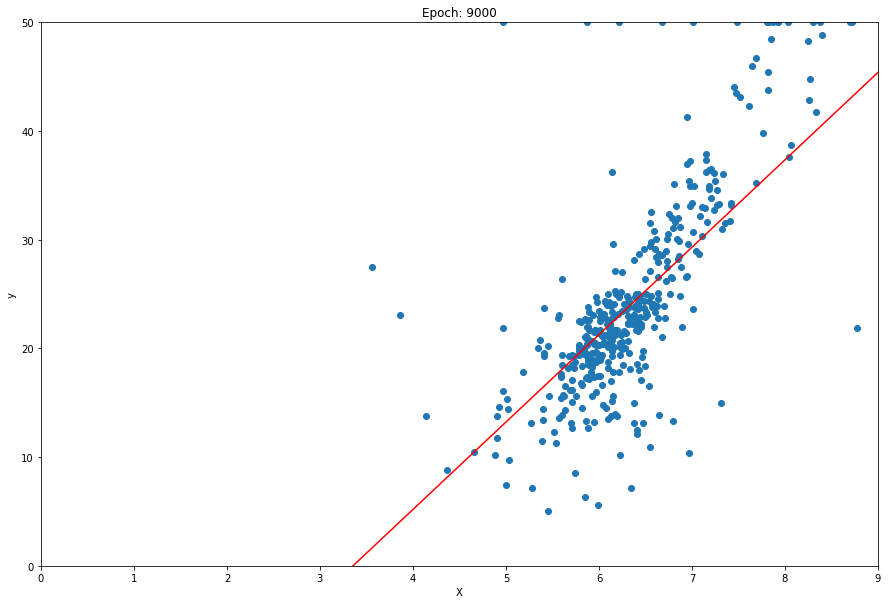

37.926502459457794 8.8663686044166 -31.91222724256137
38.84901827481733 8.039189166790752 -26.97465854361373
epoch:  9500 average loss:  38.96651458199922
Momentum leader: gradient_w2 = -24.11156243975616, gradient_b2 = -2.085223702323225, MAX_w_gradient = 195.14182275460618 and b = 28.797005071724396
Momentum leader: mw1 = 0.00012631858155381898, mb1 = -0.0008106755876438338
Momentum leader: guidance_w2 = 0.9999868039331724, guidance_b2 = 0.9999779921490851
Adam follower: mw2 = 12.531183095124618, mb2 = 0.49861019868763323, sw2 = 1.5713613276476908, sb2 = 0.012402432230651043


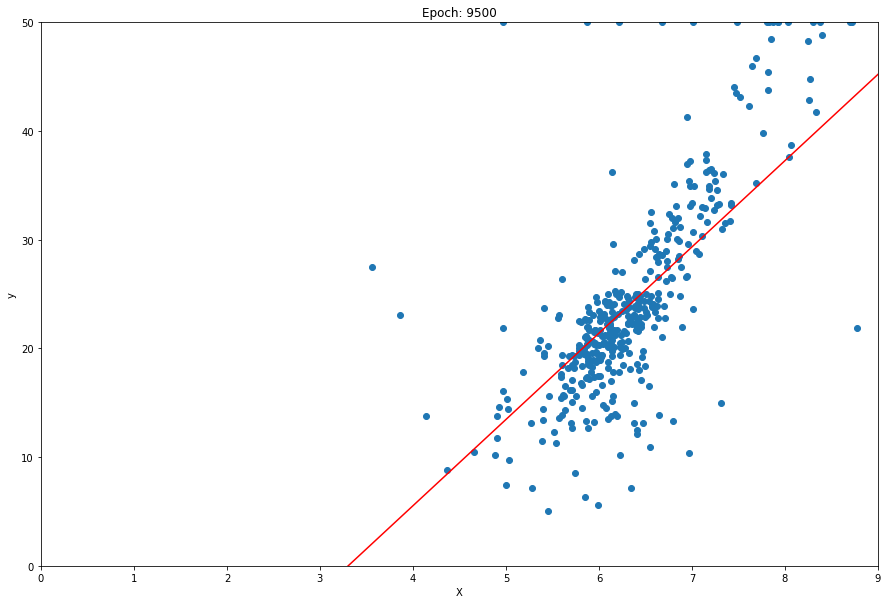

37.88823461060878 8.933750823840542 -32.34466655320126
38.96651458199922 7.935632964818106 -26.218683484647485
epoch:  10000 average loss:  38.68804234560332
Momentum leader: gradient_w2 = 78.64643687632866, gradient_b2 = 11.574473593927493, MAX_w_gradient = 195.14182275460618 and b = 28.797005071724396
Momentum leader: mw1 = 0.00011110549758259482, mb1 = -0.0007130424790657173
Momentum leader: guidance_w2 = 0.9974451980018338, guidance_b2 = 0.9974728613509232
Adam follower: mw2 = -39.71108414780633, mb2 = -0.12299618455364122, sw2 = 15.770846330092546, sb2 = 0.3421289750474258


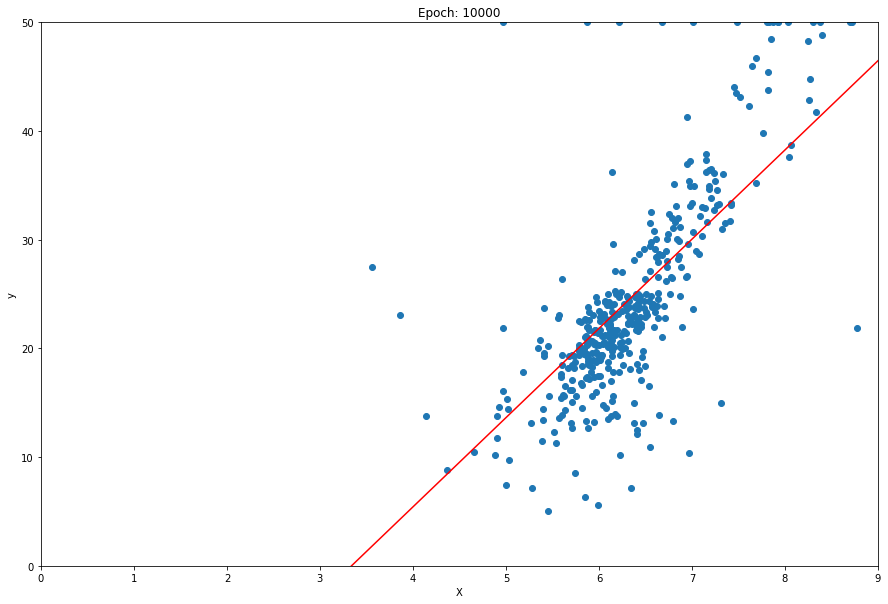

37.85862922877691 8.993017916023055 -32.72502535862717
38.68804234560332 8.207169327931167 -27.40961146229614
epoch:  10500 average loss:  38.51444336051634
Momentum leader: gradient_w2 = 51.22833175317154, gradient_b2 = 8.673884760007827, MAX_w_gradient = 195.14182275460618 and b = 28.797005071724396
Momentum leader: mw1 = 9.772459001033073e-05, mb1 = -0.0006271677409578008
Momentum leader: guidance_w2 = 0.9993731575662208, guidance_b2 = 0.9990770368335145
Adam follower: mw2 = -26.023565528492913, mb2 = -0.4758906963835132, sw2 = 6.773366705395235, sb2 = 0.1937299321381311


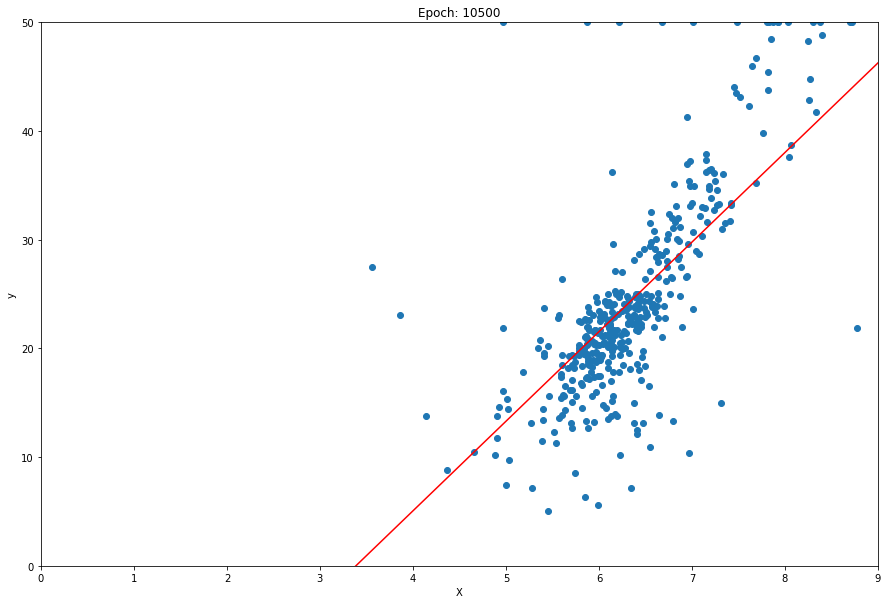

37.83572544244527 9.045147220249003 -33.05957593556465
38.51444336051634 8.240072942554068 -27.9058852827562
epoch:  11000 average loss:  38.83241991526661
Momentum leader: gradient_w2 = -25.10899525679066, gradient_b2 = -2.3739031326447995, MAX_w_gradient = 195.14182275460618 and b = 28.797005071724396
Momentum leader: mw1 = 8.595520204270665e-05, mb1 = -0.0005516352627594278
Momentum leader: guidance_w2 = 0.999987461478931, guidance_b2 = 0.9999800913778555
Adam follower: mw2 = 12.999448864811683, mb2 = 0.27699012798712636, sw2 = 1.6898450553497968, sb2 = 0.015731319660523158


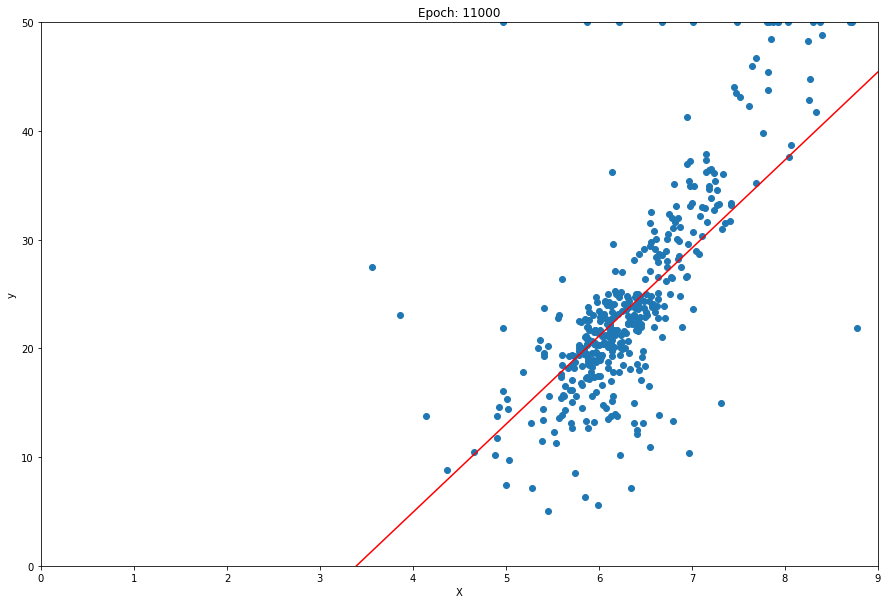

37.818006251005514 9.09099837067684 -33.353835163778996
38.83241991526661 8.10111338729334 -27.482769075095685
epoch:  11500 average loss:  38.64751404798289
Momentum leader: gradient_w2 = 94.48797020937431, gradient_b2 = 15.50511332059043, MAX_w_gradient = 195.14182275460618 and b = 28.797005071724396
Momentum leader: mw1 = 7.560325151924459e-05, mb1 = -0.0004851994821273244
Momentum leader: guidance_w2 = 0.9942467170854923, guidance_b2 = 0.9901049454070427
Adam follower: mw2 = -47.608365541307805, mb2 = -0.3393619980666573, sw2 = 22.684452266862923, sb2 = 0.61068886271495


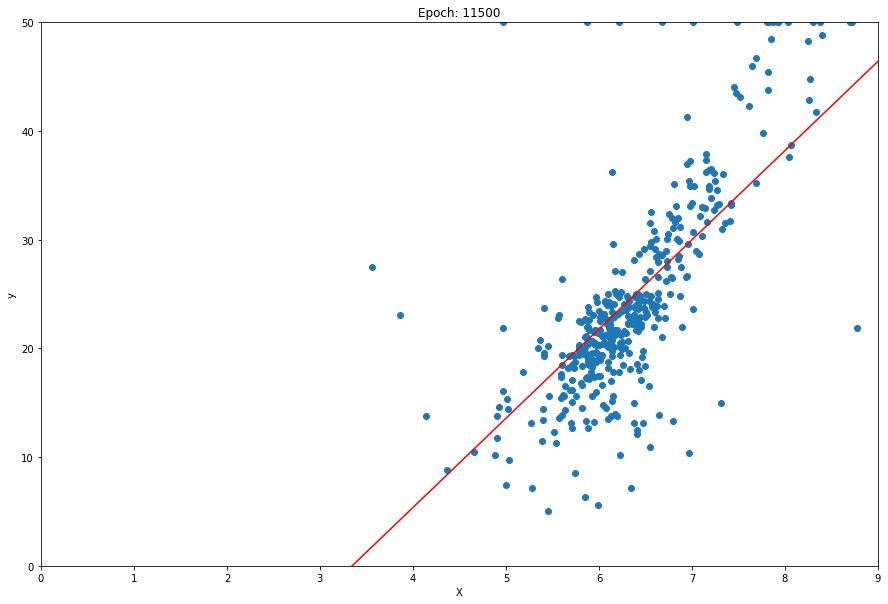

37.80429804832094 9.131327472067582 -33.612655501744044
38.64751404798289 8.208098366901744 -27.47272020295935
epoch:  12000 average loss:  38.8403341643675
Momentum leader: gradient_w2 = 54.66698109152468, gradient_b2 = 8.968034250829328, MAX_w_gradient = 195.14182275460618 and b = 28.797005071724396
Momentum leader: mw1 = 6.649803042059128e-05, mb1 = -0.00042676484508807845
Momentum leader: guidance_w2 = 0.9992523701219629, guidance_b2 = 0.9989777767516903
Adam follower: mw2 = -27.7279896970957, mb2 = -1.3179407225655693, sw2 = 7.689783368907902, sb2 = 0.20687403516076797


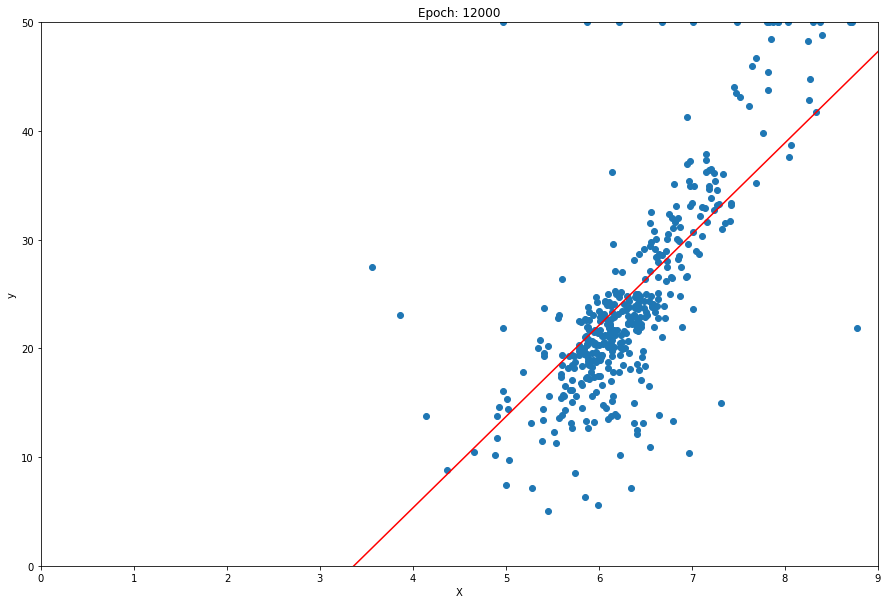

37.79369289054719 9.166799568270378 -33.84030500572339
38.8403341643675 8.39298187569997 -28.24213377405894
epoch:  12500 average loss:  38.34449591198204
Momentum leader: gradient_w2 = -1.7924059661431546, gradient_b2 = 0.4253176983270786, MAX_w_gradient = 195.14182275460618 and b = 28.797005071724396
Momentum leader: mw1 = 5.8489389820848746e-05, mb1 = -0.0003753677398922885
Momentum leader: guidance_w2 = 0.9999585843384957, guidance_b2 = 0.9999473742431827
Adam follower: mw2 = 2.683312869466621, mb2 = 1.41199986761177, sw2 = 0.07199678534987297, sb2 = 4.3331481790844114e-05


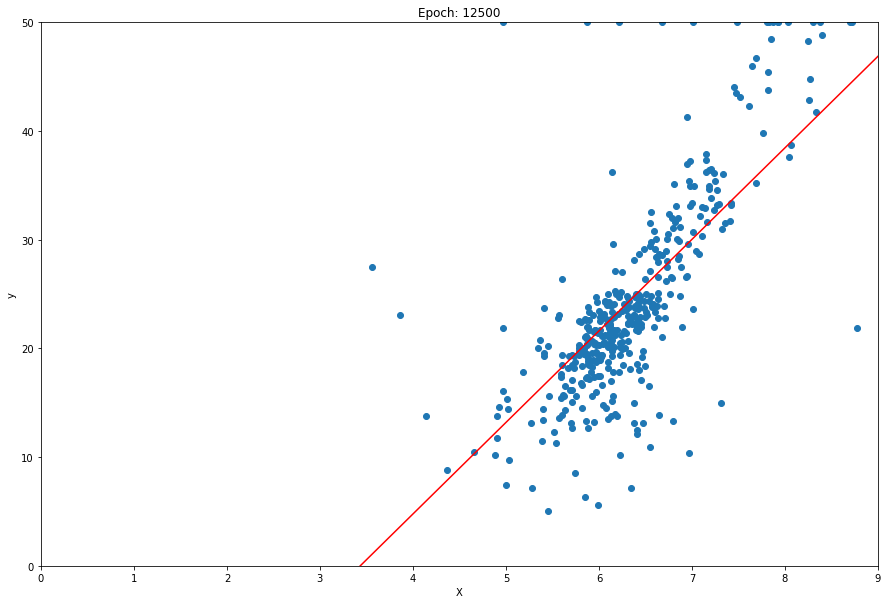

37.78548835972767 9.197999609075362 -34.04053771181397
38.34449591198204 8.418952194817141 -28.908275153237152
epoch:  13000 average loss:  38.52086344817181
Momentum leader: gradient_w2 = -47.72273919849893, gradient_b2 = -5.685537182711281, MAX_w_gradient = 195.14182275460618 and b = 28.797005071724396
Momentum leader: mw1 = 5.144526386791284e-05, mb1 = -0.0003301606066514299
Momentum leader: guidance_w2 = 0.9999960647703858, guidance_b2 = 0.999993696151064
Adam follower: mw2 = 24.28004105571801, mb2 = -1.0697362941191053, sw2 = 5.895216767685613, sb2 = 0.08438608825097563


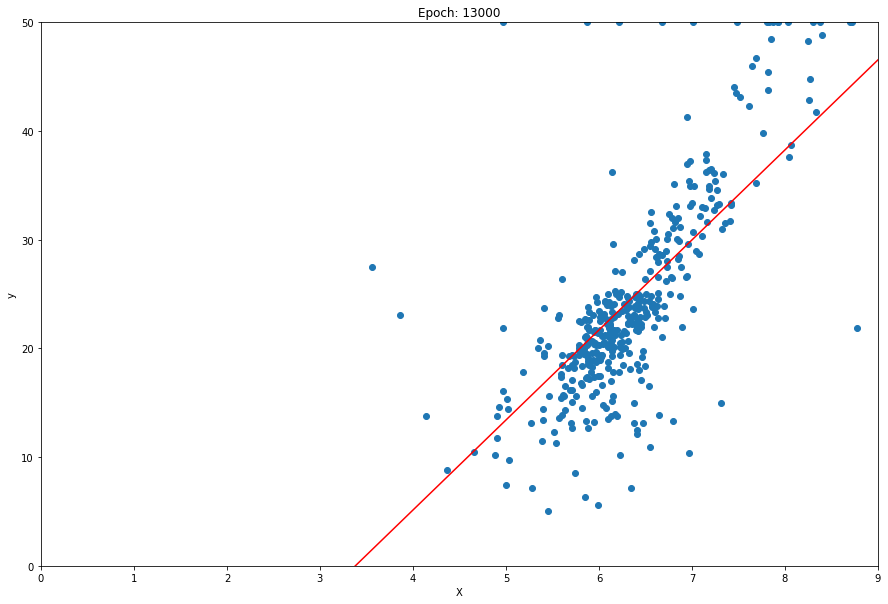

37.779141040111625 9.225442096281848 -34.216655541580785
38.52086344817181 8.281226365781619 -27.996659208288065
epoch:  13500 average loss:  38.43934756537154
Momentum leader: gradient_w2 = 3.649440137484907, gradient_b2 = -1.3568238420559127, MAX_w_gradient = 195.14182275460618 and b = 28.797005071724396
Momentum leader: mw1 = 4.524949195883758e-05, mb1 = -0.0002903979607192234
Momentum leader: guidance_w2 = 0.9999452637979751, guidance_b2 = 0.9999716580745991
Adam follower: mw2 = -2.2670145351089483, mb2 = -0.02149861896296192, sw2 = 0.0505147345323555, sb2 = 0.0037668657761937524


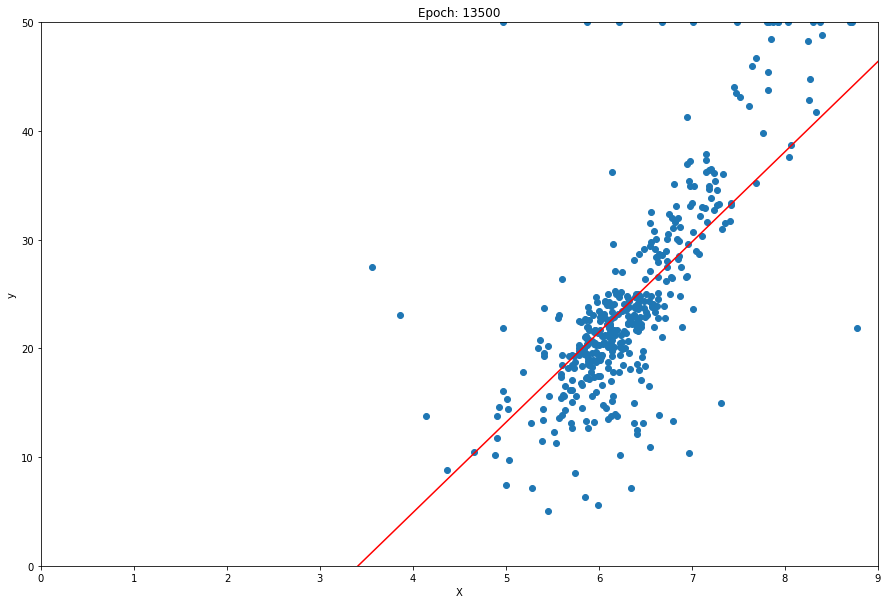

37.774230525763556 9.249579568049455 -34.371562752132924
38.43934756537154 8.298018255078967 -28.298042723933435
epoch:  14000 average loss:  37.77906429620702
Momentum leader: gradient_w2 = 24.63840074174509, gradient_b2 = 4.202873443858943, MAX_w_gradient = 195.14182275460618 and b = 28.797005071724396
Momentum leader: mw1 = 3.9799903209969506e-05, mb1 = -0.00025542409933504944
Momentum leader: guidance_w2 = 0.9998395311228664, guidance_b2 = 0.9998046108155411
Adam follower: mw2 = -12.76782155020274, mb2 = -0.6991614820712897, sw2 = 1.6302630104308762, sb2 = 0.047078737277329856


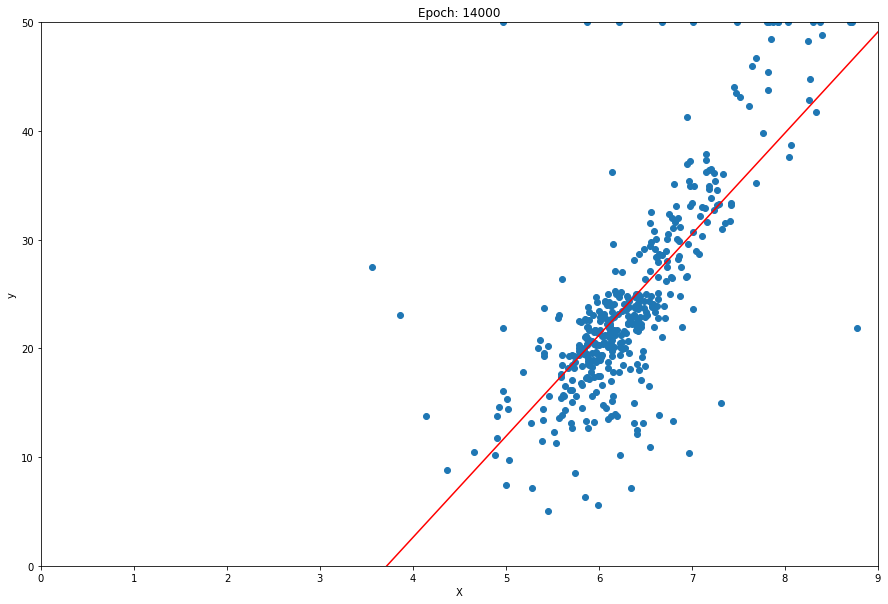

291.34031105041504


In [18]:
start_time = time.time()
w_list, b_list, avg_loss_list, w, b, img_list, pred_val_at_diff_epoch = train(df["RM"][0:403], df["Y"][0:403], 0, 0, 0, 0, 0.001, 1000000, 0.9, 0.99, 0.0000001)
print(f"{time.time() - start_time}")

In [19]:
print(len(w_list))
print(len(b_list))
print(len(avg_loss_list))
print("best value for w: ",w)
print("best value for b: ",b)
print(len(img_list))
print(len(pred_val_at_diff_epoch))

1401
1401
1401
best value for w:  9.270810061442736
best value for b:  -34.50781382854485
29
0


In [20]:
len(avg_loss_list)*10

14010

In [21]:
min(avg_loss_list)

37.76793664065815

In [22]:
n = np.linspace(10, _, 1401, endpoint = True)
len(n)

1401

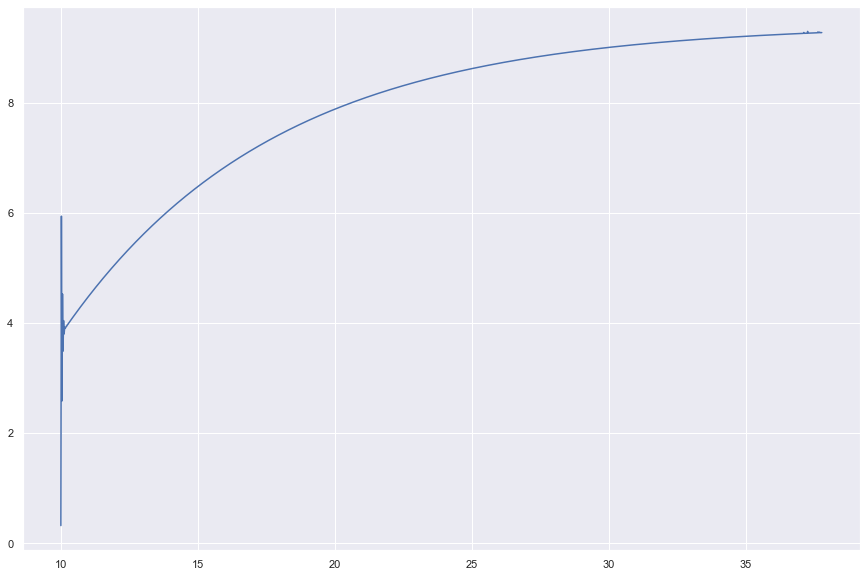

In [23]:
sns.set(rc = {"figure.figsize" : (15, 10)})
plt.plot(n, w_list)
plt.show()

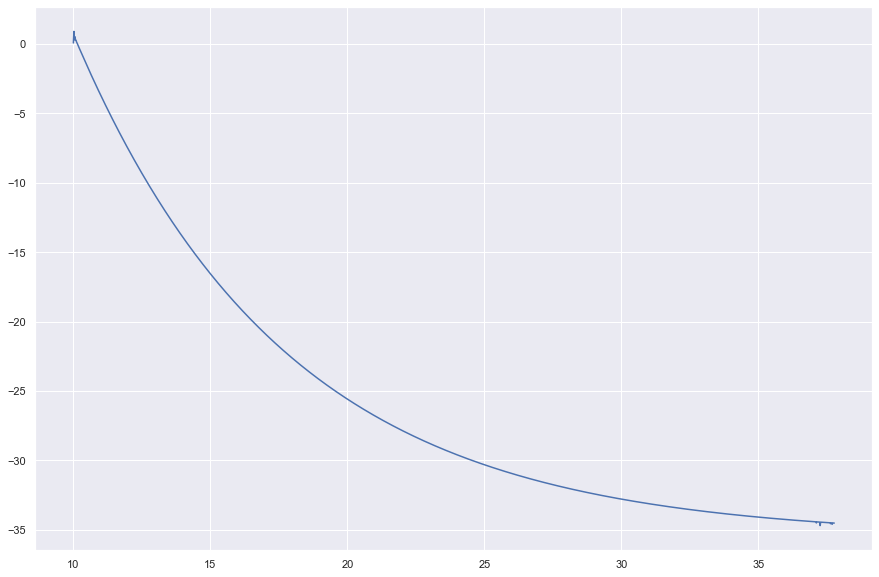

In [24]:
plt.plot(n, b_list)
plt.show()

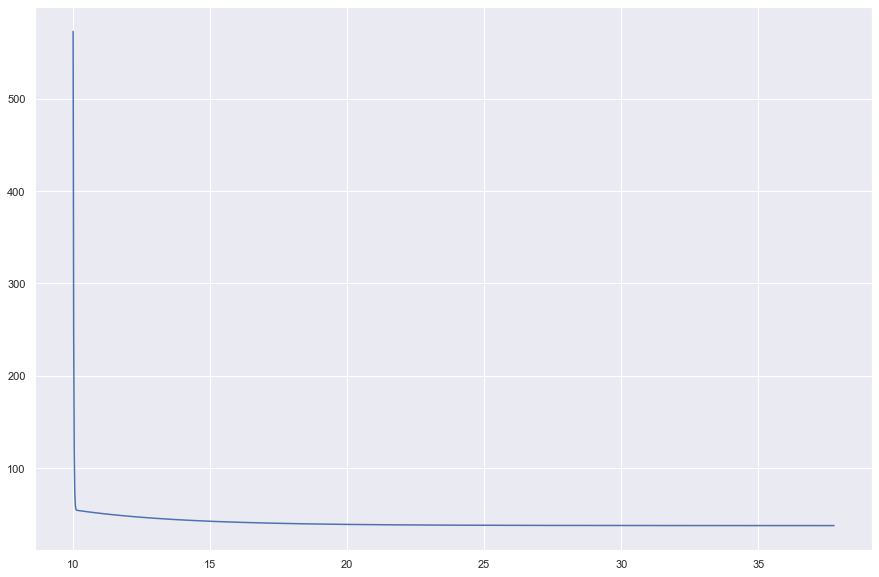

In [25]:
plt.plot(n, avg_loss_list)
plt.show()

In [26]:
import imageio
with imageio.get_writer('gradient_descent_01.gif', mode='I') as writer:
    for filename in img_list:
        image = imageio.imread(filename)
        writer.append_data(image)